# **PART 1: PROCESS AND SAVE**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


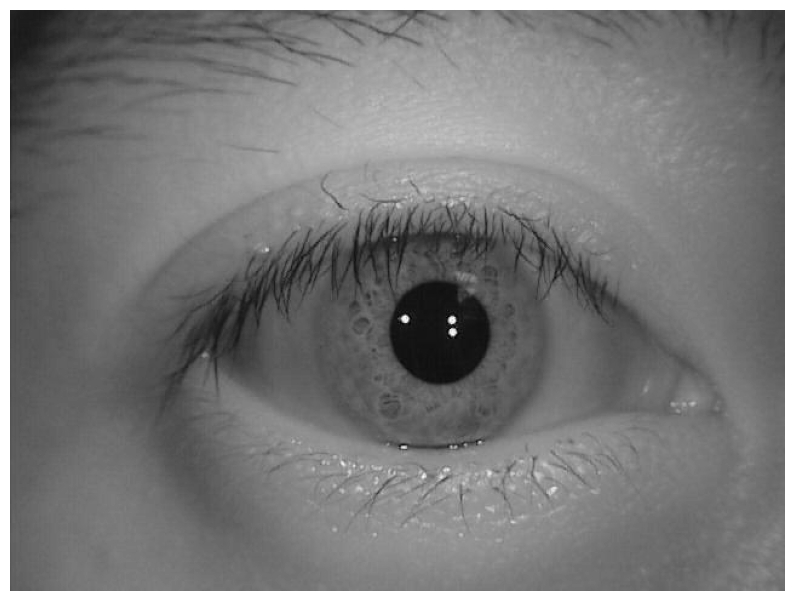

Getting iris boundaries..


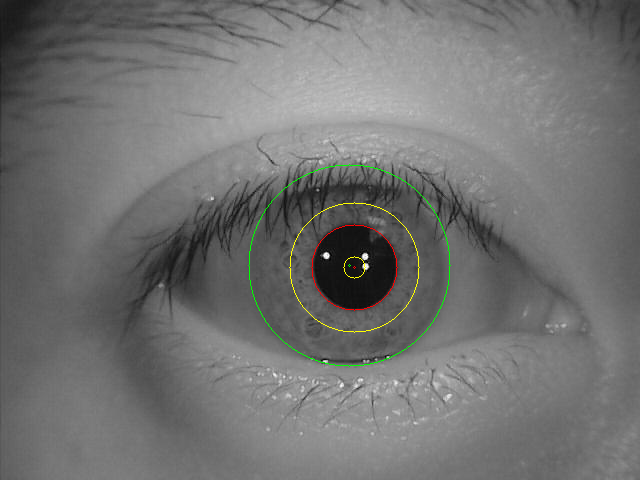

Equalizing histogram ..


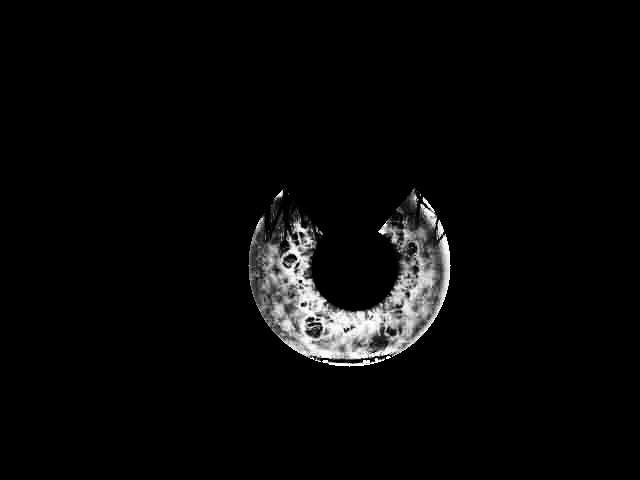

Getting roi iris images ...


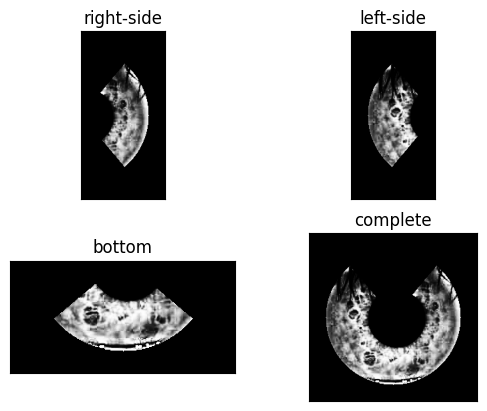

Saved right-side ROI to /content/drive/My Drive/SavedImages/right-side.jpg
Saved left-side ROI to /content/drive/My Drive/SavedImages/left-side.jpg
Saved bottom ROI to /content/drive/My Drive/SavedImages/bottom.jpg
Saved complete ROI to /content/drive/My Drive/SavedImages/complete.jpg
Searching for keypoints ... 



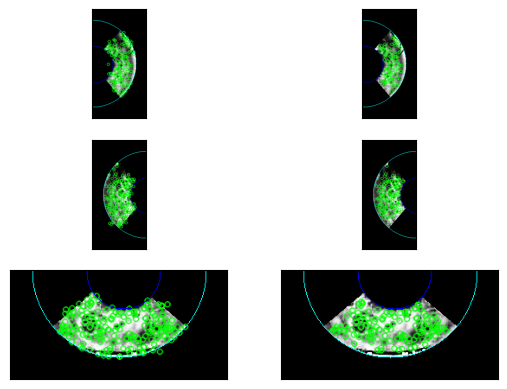

In [9]:

import numpy as np
import cv2
import os
import sys
import math
import random
import pickle
import copy
import gzip
import inspect
import itertools
from google.colab.patches import cv2_imshow
from google.colab import drive
from matplotlib import pyplot as plt

drive.mount('/content/drive')

def load_image(filepath, show=False):
    # Load the image in grayscale
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    # Display the image if requested
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    return img

def load_rois_from_bin(bin_path):
    with gzip.open(bin_path, 'rb') as bin_file:
        rois = pickle.load(bin_file)
    unpickle_rois(rois)
    return rois

def get_iris_boundaries(img, show=False):
    # Finding iris inner boundary
    pupil_circle = find_pupil(img)

    if not pupil_circle:
        print('ERROR: Pupil circle not found!')
        return None, None

    # Finding iris outer boundary
    radius_range = int(math.ceil(pupil_circle[2]*1.5))
    multiplier = 0.25
    center_range = int(math.ceil(pupil_circle[2]*multiplier))
    ext_iris_circle = find_ext_iris(
                        img, pupil_circle, center_range, radius_range)

    while(not ext_iris_circle and multiplier <= 0.7):
        multiplier += 0.05
        print('Searching exterior iris circle with multiplier ') + \
              str(multiplier)
        center_range = int(math.ceil(pupil_circle[2]*multiplier))
        ext_iris_circle = find_ext_iris(img, pupil_circle,
                                        center_range, radius_range)
    if not ext_iris_circle:
        print('ERROR: Exterior iris circle not found!')
        return None, None

    if show:
        cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
        draw_circles(cimg, pupil_circle, ext_iris_circle,
                     center_range, radius_range)
        cv2_imshow(cimg)
        ch = cv2.waitKey(0)
        cv2.destroyAllWindows()

    return pupil_circle, ext_iris_circle

def load_rois_from_image(filepath):
    img = load_image(filepath, show=True)

    print("Getting iris boundaries..")
    pupil_circle, ext_iris_circle = get_iris_boundaries(img, show=True)
    if not pupil_circle or not ext_iris_circle:
        print("Error finding iris boundaries!")
        return

    print("Equalizing histogram ..")
    roi = get_equalized_iris(img, ext_iris_circle, pupil_circle, show=True)

    print("Getting roi iris images ...")
    rois = get_rois(roi, pupil_circle, ext_iris_circle, show=True)

    print("Searching for keypoints ... \n")
    sift = cv2.xfeatures2d.SIFT_create()
    load_keypoints(sift, rois, show=True)
    load_descriptors(sift, rois)

    return rois

def get_edges(image):
    # Detect edges using the Canny algorithm
    edges = cv2.Canny(image, 20, 100)
    # Define a 3x3 kernel for dilation
    kernel = np.ones((3, 3), np.uint8)
    # Dilate the edges
    edges = cv2.dilate(edges, kernel, iterations=2)
    # Determine a random kernel size for Gaussian blur, ensuring it is odd
    k_size = 2 * random.randint(5, 10) + 1
    # Apply Gaussian blur to the edges
    edges = cv2.GaussianBlur(edges, (k_size, k_size), 0)
    return edges

def find_pupil(img):
    param1 = 200
    param2 = 120
    pupil_circles = []

    while param2 > 35 and len(pupil_circles) < 100:
        for mdn, thrs in [(m, t) for m in [3, 5, 7] for t in [20, 25, 30, 35, 40, 45, 50, 55, 60]]:
            # Median Blur
            median = cv2.medianBlur(img, 2 * mdn + 1)

            # Threshold
            ret, thres = cv2.threshold(median, thrs, 255, cv2.THRESH_BINARY_INV)

            # Fill Contours
            contours, hierarchy = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            thres = cv2.drawContours(thres, contours, -1, (255), -1)

            # Canny Edges
            edges = get_edges(thres)

            # HoughCircles
            circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 1, param1=param1, param2=param2, minRadius=0, maxRadius=0)
            if circles is not None and len(circles) > 0:
                circles = np.round(circles[0, :]).astype("int")
                pupil_circles.extend(circles)

        param2 -= 1

    cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    return get_mean_circle(pupil_circles)

def get_mean_circle(circles, draw=None):
    if not circles:
        return None

    # Calculate mean values for the circle parameters
    mean_x = int(np.mean([circle[0] for circle in circles]))
    mean_y = int(np.mean([circle[1] for circle in circles]))
    mean_radius = int(np.mean([circle[2] for circle in circles]))

    # Draw the mean circle on the image if provided
    if draw is not None:
        draw_copy = draw.copy()

        # Draw the outer circle
        cv2.circle(draw_copy, (mean_x, mean_y), mean_radius, (0, 255, 0), 1)

        # Draw the center of the circle
        cv2.circle(draw_copy, (mean_x, mean_y), 2, (0, 255, 0), 2)

        # Display the image with the mean circle
        cv2_imshow(draw_copy)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return mean_x, mean_y, mean_radius

def filtered_circles(circles, draw=None):
    # what if there are only 2 circles - which is alpha?
    def get_alpha_radius(circles0):
        alpha_circle = None
        dist_min = None
        circles1 = circles0[:]
        circles2 = circles0[:]
        for crt_c in circles1:
            dist = 0
            for c in circles2:
                dist += math.fabs(float(crt_c[2]) - float(c[2]))
            if not dist_min or dist < dist_min:
                dist_min = dist
                alpha_circle = crt_c
        return alpha_circle[2]

    if not circles:
        print('Error: empty circles list in filtered_circles() !')
        return []
    c_0_mean, c_0_dev = standard_dev([int(i[0]) for i in circles])
    c_1_mean, c_1_dev = standard_dev([int(i[1]) for i in circles])
    filtered = []
    filtered_pos = []
    not_filtered = []
    ratio = 1.5
    for c in circles[:]:
        if c[0] < c_0_mean - ratio*c_0_dev or \
           c[0] > c_0_mean + ratio*c_0_dev or \
           c[1] < c_1_mean - ratio*c_1_dev or \
           c[1] > c_1_mean + ratio*c_1_dev:
            not_filtered.append(c)
        else:
            filtered_pos.append(c)
    if len([float(c[2]) for c in filtered_pos]) < 3:
        filtered = filtered_pos
    else:
        alpha_radius = get_alpha_radius(filtered_pos)
        mean_radius, dev_radius = standard_dev(
                                    [float(c[2]) for c in filtered_pos])
        max_radius = alpha_radius + dev_radius
        min_radius = alpha_radius - dev_radius
        for c in filtered_pos:
            if c[2] < min_radius or \
               c[2] > max_radius:
                not_filtered.append(c)
            else:
                filtered.append(c)

    if draw is not None:
        draw = draw.copy()
        for circle in not_filtered:
            # draw the outer circle
            cv2.circle(draw,(circle[0],circle[1]),circle[2],(255,0,0),1)
            # draw the center of the circle
            cv2.circle(draw,(circle[0],circle[1]),2,(255,0,0),2)
        for circle in filtered:
            # draw the outer circle
            cv2.circle(draw,(circle[0],circle[1]),circle[2],(0,255,0),1)
            # draw the center of the circle
            cv2.circle(draw,(circle[0],circle[1]),2,(0,255,0),2)
        cv2_imshow('filtered_circles() total={0} filtered_pos={1} filtered={2}'.\
                   format(len(circles), len(filtered_pos), len(filtered)),
                   draw)
        ch = cv2.waitKey(0)
        cv2.destroyAllWindows()
    return filtered

def find_ext_iris(img, pupil_circle, center_range, radius_range):
    def get_edges(image, thrs2):
      thrs1 = 0  # 0
      edges = cv2.Canny(image, thrs1, thrs2, apertureSize=5)
      kernel = np.ones((3, 3), np.uint8)
      edges = cv2.dilate(edges, kernel, iterations=1)
      ksize = 2 * random.randrange(5, 11) + 1
      edges = cv2.GaussianBlur(edges, (ksize, ksize), 0)
      return edges

    def get_circles(img, hough_param, median_params, edge_params, pupil_circle, center_range, radius_range):
      crt_circles = []
      for mdn, thrs2 in [(m, t) for m in median_params for t in edge_params]:
          # Median Blur
          median = cv2.medianBlur(img, 2 * mdn + 1)

          # Canny Edges
          edges = get_edges(median, thrs2)

          # HoughCircles
          circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 1, param1=200, param2=hough_param, minRadius=0, maxRadius=0)
          if circles is not None and circles.any():
              circles = np.round(circles[0, :]).astype("int")
              for (c_col, c_row, r) in circles:
                  if point_in_circle(int(pupil_circle[0]), int(pupil_circle[1]), center_range, c_col, c_row) and r > radius_range:
                      crt_circles.append((c_col, c_row, r))
      return crt_circles


    param2 = 120  # 150
    total_circles = []

    while param2 > 40 and len(total_circles) < 50:
        crt_circles = get_circles(img, param2, [8, 10, 12, 14, 16, 18, 20], [430, 480, 530], pupil_circle, center_range, radius_range)
        if crt_circles:
            total_circles += crt_circles
        param2 -= 1

    if not total_circles:
        print("Running plan B on finding ext iris circle")
        param2 = 120
        while param2 > 40 and len(total_circles) < 50:
            crt_circles = get_circles(img, param2, [3, 5, 7, 21, 23, 25], [430, 480, 530], pupil_circle, center_range, radius_range)
            if crt_circles:
                total_circles += crt_circles
            param2 -= 1

    if not total_circles:
        return None

    cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    filtered = filtered_circles(total_circles)

    return get_mean_circle(filtered)


def point_in_circle(c_col, c_row, c_radius, p_col, p_row):
    return distance(c_col, c_row, p_col, p_row) <= c_radius


def draw_circles(cimg, pupil_circle, ext_iris_circle,
                 center_range=None, radius_range=None):
    # draw the outer pupil circle
    cv2.circle(cimg,(pupil_circle[0], pupil_circle[1]), pupil_circle[2],
                     (0,0,255),1)
    # draw the center of the pupil circle
    cv2.circle(cimg,(pupil_circle[0],pupil_circle[1]),1,(0,0,255),1)
    if center_range:
        # draw ext iris center range limit
        cv2.circle(cimg,(pupil_circle[0], pupil_circle[1]), center_range,
                         (0,255,255),1)
    if radius_range:
        # draw ext iris radius range limit
        cv2.circle(cimg,(pupil_circle[0], pupil_circle[1]), radius_range,
                         (0,255,255),1)
    # draw the outer ext iris circle
    cv2.circle(cimg, (ext_iris_circle[0], ext_iris_circle[1]),
               ext_iris_circle[2],(0,255,0),1)
    # draw the center of the ext iris circle
    cv2.circle(cimg, (ext_iris_circle[0], ext_iris_circle[1]),
               1,(0,255,0),1)

def get_equalized_iris(img, ext_iris_circle, pupil_circle, show=False):
    def find_roi():
        mask = img.copy()
        mask[:] = (0)

        cv2.circle(mask,
                   (ext_iris_circle[0], ext_iris_circle[1]),
                   ext_iris_circle[2], (255), -1)
        cv2.circle(mask,
                   (pupil_circle[0],pupil_circle[1]),
                   pupil_circle[2],(0), -1)

        roi = cv2.bitwise_and(img, mask)

        return roi

    roi = find_roi()

    # Mask the top side of the iris
    for p_col in range(roi.shape[1]):
        for p_row in range(roi.shape[0]):
            theta = angle_v(ext_iris_circle[0], ext_iris_circle[1],
                            p_col, p_row)
            if theta > 50 and theta < 130:
                roi[p_row,p_col] = 0

    ret, roi = cv2.threshold(roi,50,255,cv2.THRESH_TOZERO)

    equ_roi = roi.copy()
    cv2.equalizeHist(roi, equ_roi)
    roi = cv2.addWeighted(roi, 0.0, equ_roi, 1.0, 0)

    if show:
        cv2_imshow(roi)
        ch = cv2.waitKey(0)
        cv2.destroyAllWindows()

    return roi

def save_rois(rois):
    folder_path='/content/drive/My Drive/SavedImages'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)


    for pos in rois:
        roi_image_path = os.path.join(folder_path, f'{pos}.jpg')
        cv2.imwrite(roi_image_path, rois[pos]['img'])
        print(f"Saved {pos} ROI to {roi_image_path}")

def get_rois(img, pupil_circle, ext_circle, show=False):
    bg = img.copy()
    bg[:] = 0

    init_dict = {'img': bg.copy(),
                 'pupil_circle': pupil_circle,
                 'ext_circle': ext_circle,
                 'kp': None,
                 'img_kp_init': bg.copy(),
                 'img_kp_filtered': bg.copy(),
                 'des': None
                 }

    rois = {'right-side': copy.deepcopy(init_dict),
            'left-side': copy.deepcopy(init_dict),
            'bottom': copy.deepcopy(init_dict),
            'complete': copy.deepcopy(init_dict)
            }

    for p_col in range(img.shape[1]):
        for p_row in range(img.shape[0]):
            if not point_in_circle(pupil_circle[0], pupil_circle[1],
                                   pupil_circle[2], p_col, p_row) and \
               point_in_circle(ext_circle[0], ext_circle[1], ext_circle[2],
                               p_col, p_row):
                theta = angle_v(ext_circle[0], ext_circle[1], p_col, p_row)
                if theta >= -50 and theta <= 50:
                    rois['right-side']['img'][p_row, p_col] = img[p_row, p_col]
                if theta >= 130 or theta <= -130:
                    rois['left-side']['img'][p_row, p_col] = img[p_row, p_col]
                if theta >= -140 and theta <= -40:
                    rois['bottom']['img'][p_row, p_col] = img[p_row, p_col]
                rois['complete']['img'][p_row, p_col] = img[p_row, p_col]

    rois['right-side']['ext_circle'] = \
            (0, int(1.25 * ext_circle[2]), int(ext_circle[2]))
    rois['left-side']['ext_circle'] = \
            (int(1.25 * ext_circle[2]),
             int(1.25 * ext_circle[2]),
             int(ext_circle[2]))
    rois['bottom']['ext_circle'] = \
            (int(1.25 * ext_circle[2]), 0, int(ext_circle[2]))
    rois['complete']['ext_circle'] = \
            (int(1.25 * ext_circle[2]),
             int(1.25 * ext_circle[2]),
             int(ext_circle[2]))

    for pos in ['right-side', 'left-side', 'bottom', 'complete']:
        tx = rois[pos]['ext_circle'][0] - ext_circle[0]
        ty = rois[pos]['ext_circle'][1] - ext_circle[1]
        rois[pos]['pupil_circle'] = (int(tx + pupil_circle[0]),
                                     int(ty + pupil_circle[1]),
                                     int(pupil_circle[2]))
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        rois[pos]['img'] = cv2.warpAffine(
                            rois[pos]['img'], M,
                            (img.shape[1], img.shape[0]))

    right_side_h = int(2.5 * ext_circle[2])
    right_side_w = int(1.25 * ext_circle[2])
    rois['right-side']['img'] = rois['right-side']['img'][:right_side_h, :right_side_w]

    left_side_h = int(2.5 * ext_circle[2])
    left_side_w = int(1.25 * ext_circle[2])
    rois['left-side']['img'] = rois['left-side']['img'][:left_side_h, :left_side_w]

    bottom_h = int(1.25 * ext_circle[2])
    bottom_w = int(2.5 * ext_circle[2])
    rois['bottom']['img'] = rois['bottom']['img'][:bottom_h, :bottom_w]

    complete_h = int(2.5 * ext_circle[2])
    complete_w = int(2.5 * ext_circle[2])
    rois['complete']['img'] = rois['complete']['img'][:complete_h, :complete_w]

    if show:
        plt.subplot(2, 2, 1)
        plt.imshow(rois['right-side']['img'], cmap='gray')
        plt.title('right-side')
        plt.xticks([]), plt.yticks([])

        plt.subplot(2, 2, 2)
        plt.imshow(rois['left-side']['img'], cmap='gray')
        plt.title('left-side')
        plt.xticks([]), plt.yticks([])

        plt.subplot(2, 2, 3)
        plt.imshow(rois['bottom']['img'], cmap='gray')
        plt.title('bottom')
        plt.xticks([]), plt.yticks([])

        plt.subplot(2, 2, 4)
        plt.imshow(rois['complete']['img'], cmap='gray')
        plt.title('complete')
        plt.xticks([]), plt.yticks([])

        plt.show()

    # Save ROIs to specified folder
    save_rois(rois)

    return rois

def load_keypoints(sift, rois, show=False):
    bf = cv2.BFMatcher()
    for pos in ['right-side', 'left-side', 'bottom', 'complete']:
        rois[pos]['kp'] = sift.detect(rois[pos]['img'], None)

        # Create image with non-filtered keypoints
        rois[pos]['img_kp_init'] = cv2.drawKeypoints(
            rois[pos]['img'], rois[pos]['kp'],
            outImage=None, color=(0, 255, 0), flags=0
        )
        cv2.circle(
            rois[pos]['img_kp_init'],
            (rois[pos]['pupil_circle'][0], rois[pos]['pupil_circle'][1]),
            rois[pos]['pupil_circle'][2], (0, 0, 255), 1
        )
        cv2.circle(
            rois[pos]['img_kp_init'],
            (rois[pos]['ext_circle'][0], rois[pos]['ext_circle'][1]),
            rois[pos]['ext_circle'][2], (0, 255, 255), 1
        )

        # Filter detected keypoints
        filtered_kp = []
        inside = 0
        outside = 0
        wrong_angle = 0

        for kp in rois[pos]['kp']:
            c_angle = angle_v(rois[pos]['ext_circle'][0],
                              rois[pos]['ext_circle'][1],
                              kp.pt[0], kp.pt[1])
            if point_in_circle(rois[pos]['pupil_circle'][0],
                               rois[pos]['pupil_circle'][1],
                               rois[pos]['pupil_circle'][2] + 3,
                               kp.pt[0], kp.pt[1]):
                inside += 1
            elif not point_in_circle(rois[pos]['ext_circle'][0],
                                     rois[pos]['ext_circle'][1],
                                     rois[pos]['ext_circle'][2] - 5,
                                     kp.pt[0], kp.pt[1]):
                outside += 1
            elif (pos == 'right-side' and (c_angle <= -45 or c_angle >= 45)) or \
                 (pos == 'left-side' and (c_angle <= 135 and c_angle >= -135)) or \
                 (pos == 'bottom' and (c_angle <= -135 or c_angle >= -45)):
                wrong_angle += 1
            else:
                filtered_kp.append(kp)

        rois[pos]['kp'] = filtered_kp

        # Create images with filtered keypoints
        rois[pos]['img_kp_filtered'] = cv2.drawKeypoints(
            rois[pos]['img'], rois[pos]['kp'],
            outImage=None, color=(0, 255, 0), flags=0
        )
        cv2.circle(
            rois[pos]['img_kp_filtered'],
            (rois[pos]['pupil_circle'][0], rois[pos]['pupil_circle'][1]),
            rois[pos]['pupil_circle'][2], (0, 0, 255), 1
        )
        cv2.circle(
            rois[pos]['img_kp_filtered'],
            (rois[pos]['ext_circle'][0], rois[pos]['ext_circle'][1]),
            rois[pos]['ext_circle'][2], (0, 255, 255), 1
        )

    # Show keypoints images
    if show:
        i = 0
        for pos in ['right-side', 'left-side', 'bottom']:
            plt.subplot(3, 2, 2 * i + 1)
            plt.imshow(rois[pos]['img_kp_init'])
            plt.xticks([]), plt.yticks([])
            plt.subplot(3, 2, 2 * i + 2)
            plt.imshow(rois[pos]['img_kp_filtered'])
            plt.xticks([]), plt.yticks([])
            i += 1
        plt.show()
    # print('Save the input image successfully!')
    return rois

def load_descriptors(sift, rois):
    positions = ['right-side', 'left-side', 'bottom', 'complete']
    for pos in positions:
        # Compute keypoints and descriptors for each region of interest
        keypoints, descriptors = sift.compute(rois[pos]['img'], rois[pos]['kp'])
        rois[pos]['kp'] = keypoints
        rois[pos]['des'] = descriptors

def angle_v(x1, y1, x2, y2):
    # Calculate the angle in radians between the vector (x2 - x1, y2 - y1) and the positive x-axis
    angle_rad = math.atan2(-(y2 - y1), (x2 - x1))
    # Convert the angle from radians to degrees
    angle_deg = math.degrees(angle_rad)
    return angle_deg

def distance(x1,y1,x2,y2):
    distance = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    return distance

def mean(x):
    sum = 0.0
    for i in range(len(x)):
        sum += x[i]
    return sum/len(x)

def median(x):
    return np.median(np.array(x))

def standard_dev(x):
    if not x:
        print('Error: empty list parameter in standard_dev() !')
        print(inspect.getouterframes( inspect.currentframe() )[1])
        print
        return None, None
    m = mean(x)
    sumsq = 0.0
    for i in range(len(x)):
        sumsq += (x[i] - m) ** 2
    return m, math.sqrt(sumsq/len(x))

def unpickle_keypoints(array):
    keypoints = []
    for point in array:
        temp_kp = cv2.KeyPoint(x=point[0][0],y=point[0][1],_size=point[1],
                               _angle=point[2], _response=point[3],
                               _octave=point[4], _class_id=point[5])
        keypoints.append(temp_kp)
    return keypoints

def unpickle_rois(rois):
    positions = ['right-side', 'left-side', 'bottom', 'complete']
    for pos in positions:
        rois[pos]['kp'] = unpickle_keypoints(rois[pos]['kp'])

def pickle_keypoints(keypoints):
    unfolded = []
    for point in keypoints:
        temp = (point.pt, point.size, point.angle, point.response,
                point.octave, point.class_id)
        unfolded.append(temp)

    return unfolded

def pickle_rois(rois):
    positions = ['right-side', 'left-side', 'bottom', 'complete']
    for pos in positions:
        rois[pos]['kp'] = pickle_keypoints(rois[pos]['kp'])


if __name__ == "__main__":

    # Specify image path
    filepath1 = '/content/drive/My Drive/InputImages/S2005R07.jpg'

    if os.path.isfile(filepath1):
        load_rois_from_image(filepath1)



# **PART 2: RECOGNITION**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Analysing: /content/drive/My Drive/InputImages/S2005R09.jpg


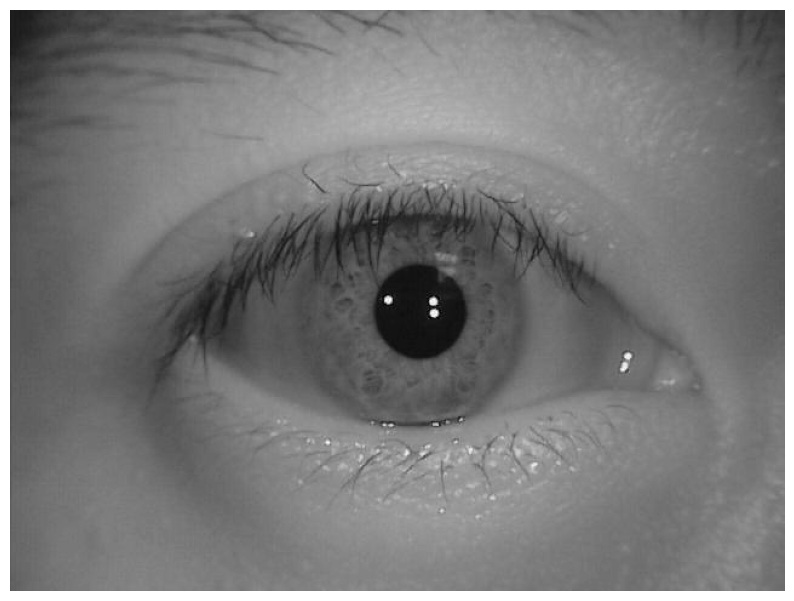

Getting iris boundaries..


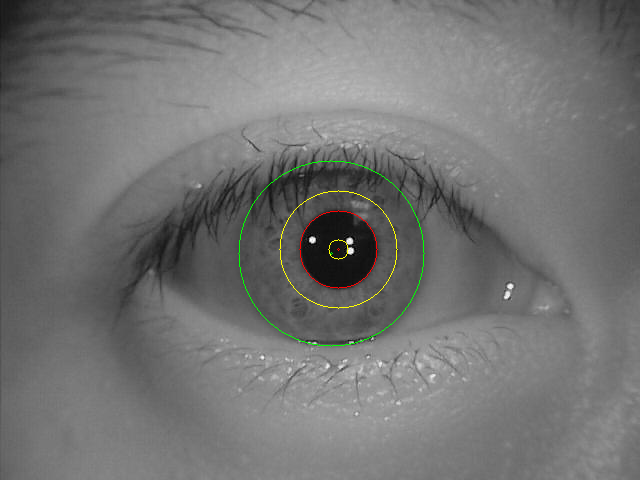

Equalizing histogram ..


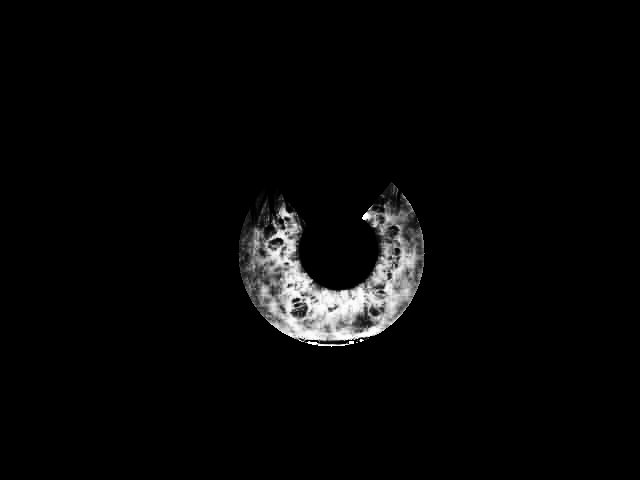

Getting roi iris images ...


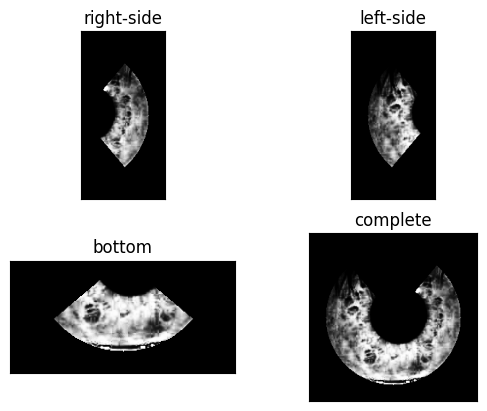

Searching for keypoints ... 

Loading: /content/drive/My Drive/SavedImages/right-side.jpg
Loading: /content/drive/My Drive/SavedImages/left-side.jpg
Loading: /content/drive/My Drive/SavedImages/complete.jpg
Loading: /content/drive/My Drive/SavedImages/bottom.jpg
right-side matches: 29


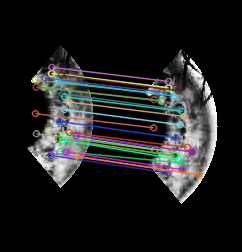

left-side matches: 38


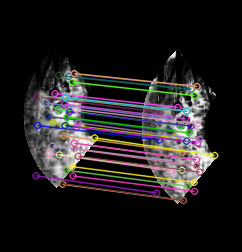

bottom matches: 47


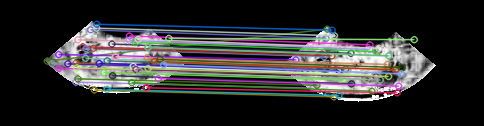

complete matches: 92


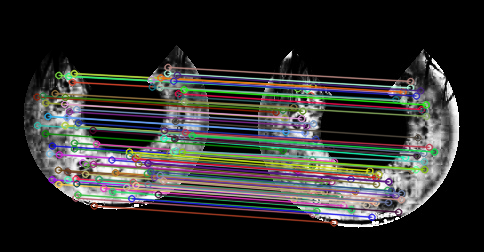

P1: 850
P2: 1074
AVG: 850
Similarity score: 0.24235294117647058
ACCEPTED IRIS !!!


In [11]:

import numpy as np
import cv2
import os
import sys
import math
import random
import pickle
import copy
import gzip
import inspect
import itertools
from google.colab.patches import cv2_imshow
from google.colab import drive
from matplotlib import pyplot as plt

drive.mount('/content/drive')

def load_image(filepath, show=False):
    # Load the image in grayscale
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    # Display the image if requested
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    return img

def load_rois_from_bin(bin_path):
    with gzip.open(bin_path, 'rb') as bin_file:
        rois = pickle.load(bin_file)
    unpickle_rois(rois)
    return rois

def get_iris_boundaries(img, show=False):
    # Finding iris inner boundary
    pupil_circle = find_pupil(img)

    if not pupil_circle:
        print('ERROR: Pupil circle not found!')
        return None, None

    # Finding iris outer boundary
    radius_range = int(math.ceil(pupil_circle[2]*1.5))
    multiplier = 0.25
    center_range = int(math.ceil(pupil_circle[2]*multiplier))
    ext_iris_circle = find_ext_iris(
                        img, pupil_circle, center_range, radius_range)

    while(not ext_iris_circle and multiplier <= 0.7):
        multiplier += 0.05
        print('Searching exterior iris circle with multiplier ') + \
              str(multiplier)
        center_range = int(math.ceil(pupil_circle[2]*multiplier))
        ext_iris_circle = find_ext_iris(img, pupil_circle,
                                        center_range, radius_range)
    if not ext_iris_circle:
        print('ERROR: Exterior iris circle not found!')
        return None, None

    if show:
        cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
        draw_circles(cimg, pupil_circle, ext_iris_circle,
                     center_range, radius_range)
        cv2_imshow(cimg)
        ch = cv2.waitKey(0)
        cv2.destroyAllWindows()

    return pupil_circle, ext_iris_circle

def load_rois_from_image(filepath):
    img = load_image(filepath, show=True)

    print("Getting iris boundaries..")
    pupil_circle, ext_iris_circle = get_iris_boundaries(img, show=True)
    if not pupil_circle or not ext_iris_circle:
        print("Error finding iris boundaries!")
        return {}

    print("Equalizing histogram ..")
    roi = get_equalized_iris(img, ext_iris_circle, pupil_circle, show=True)

    print("Getting roi iris images ...")
    rois = get_rois(roi, pupil_circle, ext_iris_circle, show=True)

    print("Searching for keypoints ... \n")
    sift = cv2.SIFT_create()

    for pos in rois:
        kp, des = sift.detectAndCompute(rois[pos]['img'], None)
        rois[pos]['kp'] = kp
        rois[pos]['des'] = des
        rois[pos]['pupil_circle'] = pupil_circle
        rois[pos]['ext_circle'] = ext_iris_circle

    return rois

def get_edges(image):
    # Detect edges using the Canny algorithm
    edges = cv2.Canny(image, 20, 100)
    # Define a 3x3 kernel for dilation
    kernel = np.ones((3, 3), np.uint8)
    # Dilate the edges
    edges = cv2.dilate(edges, kernel, iterations=2)
    # Determine a random kernel size for Gaussian blur, ensuring it is odd
    k_size = 2 * random.randint(5, 10) + 1
    # Apply Gaussian blur to the edges
    edges = cv2.GaussianBlur(edges, (k_size, k_size), 0)
    return edges

def find_pupil(img):
    param1 = 200
    param2 = 120
    pupil_circles = []

    while param2 > 35 and len(pupil_circles) < 100:
        for mdn, thrs in [(m, t) for m in [3, 5, 7] for t in [20, 25, 30, 35, 40, 45, 50, 55, 60]]:
            # Median Blur
            median = cv2.medianBlur(img, 2 * mdn + 1)

            # Threshold
            ret, thres = cv2.threshold(median, thrs, 255, cv2.THRESH_BINARY_INV)

            # Fill Contours
            contours, hierarchy = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            thres = cv2.drawContours(thres, contours, -1, (255), -1)

            # Canny Edges
            edges = get_edges(thres)

            # HoughCircles
            circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 1, param1=param1, param2=param2, minRadius=0, maxRadius=0)
            if circles is not None and len(circles) > 0:
                circles = np.round(circles[0, :]).astype("int")
                pupil_circles.extend(circles)

        param2 -= 1

    cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    return get_mean_circle(pupil_circles)

def get_mean_circle(circles, draw=None):
    if not circles:
        return None

    # Calculate mean values for the circle parameters
    mean_x = int(np.mean([circle[0] for circle in circles]))
    mean_y = int(np.mean([circle[1] for circle in circles]))
    mean_radius = int(np.mean([circle[2] for circle in circles]))

    # Draw the mean circle on the image if provided
    if draw is not None:
        draw_copy = draw.copy()

        # Draw the outer circle
        cv2.circle(draw_copy, (mean_x, mean_y), mean_radius, (0, 255, 0), 1)

        # Draw the center of the circle
        cv2.circle(draw_copy, (mean_x, mean_y), 2, (0, 255, 0), 2)

        # Display the image with the mean circle
        cv2_imshow(draw_copy)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return mean_x, mean_y, mean_radius

def filtered_circles(circles, draw=None):
    # what if there are only 2 circles - which is alpha?
    def get_alpha_radius(circles0):
        alpha_circle = None
        dist_min = None
        circles1 = circles0[:]
        circles2 = circles0[:]
        for crt_c in circles1:
            dist = 0
            for c in circles2:
                dist += math.fabs(float(crt_c[2]) - float(c[2]))
            if not dist_min or dist < dist_min:
                dist_min = dist
                alpha_circle = crt_c
        return alpha_circle[2]

    if not circles:
        print('Error: empty circles list in filtered_circles() !')
        return []
    c_0_mean, c_0_dev = standard_dev([int(i[0]) for i in circles])
    c_1_mean, c_1_dev = standard_dev([int(i[1]) for i in circles])
    filtered = []
    filtered_pos = []
    not_filtered = []
    ratio = 1.5
    for c in circles[:]:
        if c[0] < c_0_mean - ratio*c_0_dev or \
           c[0] > c_0_mean + ratio*c_0_dev or \
           c[1] < c_1_mean - ratio*c_1_dev or \
           c[1] > c_1_mean + ratio*c_1_dev:
            not_filtered.append(c)
        else:
            filtered_pos.append(c)
    if len([float(c[2]) for c in filtered_pos]) < 3:
        filtered = filtered_pos
    else:
        alpha_radius = get_alpha_radius(filtered_pos)
        mean_radius, dev_radius = standard_dev(
                                    [float(c[2]) for c in filtered_pos])
        max_radius = alpha_radius + dev_radius
        min_radius = alpha_radius - dev_radius
        for c in filtered_pos:
            if c[2] < min_radius or \
               c[2] > max_radius:
                not_filtered.append(c)
            else:
                filtered.append(c)

    if draw is not None:
        draw = draw.copy()
        for circle in not_filtered:
            # draw the outer circle
            cv2.circle(draw,(circle[0],circle[1]),circle[2],(255,0,0),1)
            # draw the center of the circle
            cv2.circle(draw,(circle[0],circle[1]),2,(255,0,0),2)
        for circle in filtered:
            # draw the outer circle
            cv2.circle(draw,(circle[0],circle[1]),circle[2],(0,255,0),1)
            # draw the center of the circle
            cv2.circle(draw,(circle[0],circle[1]),2,(0,255,0),2)
        cv2_imshow('filtered_circles() total={0} filtered_pos={1} filtered={2}'.\
                   format(len(circles), len(filtered_pos), len(filtered)),
                   draw)
        ch = cv2.waitKey(0)
        cv2.destroyAllWindows()
    return filtered

def find_ext_iris(img, pupil_circle, center_range, radius_range):
    def get_edges(image, thrs2):
      thrs1 = 0  # 0
      edges = cv2.Canny(image, thrs1, thrs2, apertureSize=5)
      kernel = np.ones((3, 3), np.uint8)
      edges = cv2.dilate(edges, kernel, iterations=1)
      ksize = 2 * random.randrange(5, 11) + 1
      edges = cv2.GaussianBlur(edges, (ksize, ksize), 0)
      return edges

    def get_circles(img, hough_param, median_params, edge_params, pupil_circle, center_range, radius_range):
      crt_circles = []
      for mdn, thrs2 in [(m, t) for m in median_params for t in edge_params]:
          # Median Blur
          median = cv2.medianBlur(img, 2 * mdn + 1)

          # Canny Edges
          edges = get_edges(median, thrs2)

          # HoughCircles
          circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 1, param1=200, param2=hough_param, minRadius=0, maxRadius=0)
          if circles is not None and circles.any():
              circles = np.round(circles[0, :]).astype("int")
              for (c_col, c_row, r) in circles:
                  if point_in_circle(int(pupil_circle[0]), int(pupil_circle[1]), center_range, c_col, c_row) and r > radius_range:
                      crt_circles.append((c_col, c_row, r))
      return crt_circles


    param2 = 120  # 150
    total_circles = []

    while param2 > 40 and len(total_circles) < 50:
        crt_circles = get_circles(img, param2, [8, 10, 12, 14, 16, 18, 20], [430, 480, 530], pupil_circle, center_range, radius_range)
        if crt_circles:
            total_circles += crt_circles
        param2 -= 1

    if not total_circles:
        print("Running plan B on finding ext iris circle")
        param2 = 120
        while param2 > 40 and len(total_circles) < 50:
            crt_circles = get_circles(img, param2, [3, 5, 7, 21, 23, 25], [430, 480, 530], pupil_circle, center_range, radius_range)
            if crt_circles:
                total_circles += crt_circles
            param2 -= 1

    if not total_circles:
        return None

    cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    filtered = filtered_circles(total_circles)

    return get_mean_circle(filtered)


def point_in_circle(c_col, c_row, c_radius, p_col, p_row):
    return distance(c_col, c_row, p_col, p_row) <= c_radius


def draw_circles(cimg, pupil_circle, ext_iris_circle,
                 center_range=None, radius_range=None):
    # draw the outer pupil circle
    cv2.circle(cimg,(pupil_circle[0], pupil_circle[1]), pupil_circle[2],
                     (0,0,255),1)
    # draw the center of the pupil circle
    cv2.circle(cimg,(pupil_circle[0],pupil_circle[1]),1,(0,0,255),1)
    if center_range:
        # draw ext iris center range limit
        cv2.circle(cimg,(pupil_circle[0], pupil_circle[1]), center_range,
                         (0,255,255),1)
    if radius_range:
        # draw ext iris radius range limit
        cv2.circle(cimg,(pupil_circle[0], pupil_circle[1]), radius_range,
                         (0,255,255),1)
    # draw the outer ext iris circle
    cv2.circle(cimg, (ext_iris_circle[0], ext_iris_circle[1]),
               ext_iris_circle[2],(0,255,0),1)
    # draw the center of the ext iris circle
    cv2.circle(cimg, (ext_iris_circle[0], ext_iris_circle[1]),
               1,(0,255,0),1)

def get_equalized_iris(img, ext_iris_circle, pupil_circle, show=False):
    def find_roi():
        mask = img.copy()
        mask[:] = (0)

        cv2.circle(mask,
                   (ext_iris_circle[0], ext_iris_circle[1]),
                   ext_iris_circle[2], (255), -1)
        cv2.circle(mask,
                   (pupil_circle[0],pupil_circle[1]),
                   pupil_circle[2],(0), -1)

        roi = cv2.bitwise_and(img, mask)

        return roi

    roi = find_roi()

    # Mask the top side of the iris
    for p_col in range(roi.shape[1]):
        for p_row in range(roi.shape[0]):
            theta = angle_v(ext_iris_circle[0], ext_iris_circle[1],
                            p_col, p_row)
            if theta > 50 and theta < 130:
                roi[p_row,p_col] = 0

    ret, roi = cv2.threshold(roi,50,255,cv2.THRESH_TOZERO)

    equ_roi = roi.copy()
    cv2.equalizeHist(roi, equ_roi)
    roi = cv2.addWeighted(roi, 0.0, equ_roi, 1.0, 0)

    if show:
        cv2_imshow(roi)
        ch = cv2.waitKey(0)
        cv2.destroyAllWindows()

    return roi

def get_rois(img, pupil_circle, ext_circle, show=False):
    bg = img.copy()
    bg[:] = 0

    init_dict = {'img': bg.copy(),
                 'pupil_circle': pupil_circle,
                 'ext_circle': ext_circle,
                 'kp': None,
                 'img_kp_init': bg.copy(),
                 'img_kp_filtered': bg.copy(),
                 'des': None
                 }

    rois = {'right-side': copy.deepcopy(init_dict),
            'left-side': copy.deepcopy(init_dict),
            'bottom': copy.deepcopy(init_dict),
            'complete': copy.deepcopy(init_dict)
            }

    for p_col in range(img.shape[1]):
        for p_row in range(img.shape[0]):
            if not point_in_circle(pupil_circle[0], pupil_circle[1],
                                   pupil_circle[2], p_col, p_row) and \
               point_in_circle(ext_circle[0], ext_circle[1], ext_circle[2],
                                   p_col, p_row):
                theta = angle_v(ext_circle[0], ext_circle[1], p_col, p_row)
                if theta >= -50 and theta <= 50:
                    rois['right-side']['img'][p_row, p_col] = img[p_row, p_col]
                if theta >= 130 or theta <= -130:
                    rois['left-side']['img'][p_row, p_col] = img[p_row, p_col]
                if theta >= -140 and theta <= -40:
                    rois['bottom']['img'][p_row, p_col] = img[p_row, p_col]
                rois['complete']['img'][p_row, p_col] = img[p_row, p_col]

    rois['right-side']['ext_circle'] = \
            (0, int(1.25 * ext_circle[2]), int(ext_circle[2]))
    rois['left-side']['ext_circle'] = \
            (int(1.25 * ext_circle[2]),
             int(1.25 * ext_circle[2]),
             int(ext_circle[2]))
    rois['bottom']['ext_circle'] = \
            (int(1.25 * ext_circle[2]), 0, int(ext_circle[2]))
    rois['complete']['ext_circle'] = \
            (int(1.25 * ext_circle[2]),
             int(1.25 * ext_circle[2]),
             int(ext_circle[2]))

    for pos in ['right-side', 'left-side', 'bottom', 'complete']:
        tx = rois[pos]['ext_circle'][0] - ext_circle[0]
        ty = rois[pos]['ext_circle'][1] - ext_circle[1]
        rois[pos]['pupil_circle'] = (int(tx + pupil_circle[0]),
                                     int(ty + pupil_circle[1]),
                                     int(pupil_circle[2]))
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        rois[pos]['img'] = cv2.warpAffine(
                            rois[pos]['img'], M,
                            (img.shape[1], img.shape[0]))

    right_side_h = int(2.5 * ext_circle[2])
    right_side_w = int(1.25 * ext_circle[2])
    rois['right-side']['img'] = rois['right-side']['img'][:right_side_h, :right_side_w]

    left_side_h = int(2.5 * ext_circle[2])
    left_side_w = int(1.25 * ext_circle[2])
    rois['left-side']['img'] = rois['left-side']['img'][:left_side_h, :left_side_w]

    bottom_h = int(1.25 * ext_circle[2])
    bottom_w = int(2.5 * ext_circle[2])
    rois['bottom']['img'] = rois['bottom']['img'][:bottom_h, :bottom_w]

    complete_h = int(2.5 * ext_circle[2])
    complete_w = int(2.5 * ext_circle[2])
    rois['complete']['img'] = rois['complete']['img'][:complete_h, :complete_w]

    if show:
        plt.subplot(2, 2, 1)
        plt.imshow(rois['right-side']['img'], cmap='gray')
        plt.title('right-side')
        plt.xticks([]), plt.yticks([])

        plt.subplot(2, 2, 2)
        plt.imshow(rois['left-side']['img'], cmap='gray')
        plt.title('left-side')
        plt.xticks([]), plt.yticks([])

        plt.subplot(2, 2, 3)
        plt.imshow(rois['bottom']['img'], cmap='gray')
        plt.title('bottom')
        plt.xticks([]), plt.yticks([])

        plt.subplot(2, 2, 4)
        plt.imshow(rois['complete']['img'], cmap='gray')
        plt.title('complete')
        plt.xticks([]), plt.yticks([])

        plt.show()

    return rois

def load_keypoints(sift, rois, show=False):
    bf = cv2.BFMatcher()
    for pos in ['right-side', 'left-side', 'bottom', 'complete']:
        rois[pos]['kp'] = sift.detect(rois[pos]['img'], None)

        # Create image with non-filtered keypoints
        rois[pos]['img_kp_init'] = cv2.drawKeypoints(
            rois[pos]['img'], rois[pos]['kp'],
            outImage=None, color=(0, 255, 0), flags=0
        )
        cv2.circle(
            rois[pos]['img_kp_init'],
            (rois[pos]['pupil_circle'][0], rois[pos]['pupil_circle'][1]),
            rois[pos]['pupil_circle'][2], (0, 0, 255), 1
        )
        cv2.circle(
            rois[pos]['img_kp_init'],
            (rois[pos]['ext_circle'][0], rois[pos]['ext_circle'][1]),
            rois[pos]['ext_circle'][2], (0, 255, 255), 1
        )

        # Filter detected keypoints
        filtered_kp = []
        inside = 0
        outside = 0
        wrong_angle = 0

        for kp in rois[pos]['kp']:
            c_angle = angle_v(rois[pos]['ext_circle'][0],
                              rois[pos]['ext_circle'][1],
                              kp.pt[0], kp.pt[1])
            if point_in_circle(rois[pos]['pupil_circle'][0],
                               rois[pos]['pupil_circle'][1],
                               rois[pos]['pupil_circle'][2] + 3,
                               kp.pt[0], kp.pt[1]):
                inside += 1
            elif not point_in_circle(rois[pos]['ext_circle'][0],
                                     rois[pos]['ext_circle'][1],
                                     rois[pos]['ext_circle'][2] - 5,
                                     kp.pt[0], kp.pt[1]):
                outside += 1
            elif (pos == 'right-side' and (c_angle <= -45 or c_angle >= 45)) or \
                 (pos == 'left-side' and (c_angle <= 135 and c_angle >= -135)) or \
                 (pos == 'bottom' and (c_angle <= -135 or c_angle >= -45)):
                wrong_angle += 1
            else:
                filtered_kp.append(kp)

        rois[pos]['kp'] = filtered_kp

        # Create images with filtered keypoints
        rois[pos]['img_kp_filtered'] = cv2.drawKeypoints(
            rois[pos]['img'], rois[pos]['kp'],
            outImage=None, color=(0, 255, 0), flags=0
        )
        cv2.circle(
            rois[pos]['img_kp_filtered'],
            (rois[pos]['pupil_circle'][0], rois[pos]['pupil_circle'][1]),
            rois[pos]['pupil_circle'][2], (0, 0, 255), 1
        )
        cv2.circle(
            rois[pos]['img_kp_filtered'],
            (rois[pos]['ext_circle'][0], rois[pos]['ext_circle'][1]),
            rois[pos]['ext_circle'][2], (0, 255, 255), 1
        )

    # Show keypoints images
    if show:
        i = 0
        for pos in ['right-side', 'left-side', 'bottom']:
            plt.subplot(3, 2, 2 * i + 1)
            plt.imshow(rois[pos]['img_kp_init'])
            plt.xticks([]), plt.yticks([])
            plt.subplot(3, 2, 2 * i + 2)
            plt.imshow(rois[pos]['img_kp_filtered'])
            plt.xticks([]), plt.yticks([])
            i += 1
        plt.show()

    return rois

def load_descriptors(sift, rois):
    positions = ['right-side', 'left-side', 'bottom', 'complete']
    for pos in positions:
        # Compute keypoints and descriptors for each region of interest
        keypoints, descriptors = sift.compute(rois[pos]['img'], rois[pos]['kp'])
        rois[pos]['kp'] = keypoints
        rois[pos]['des'] = descriptors

def detect_keypoints(img):
    # Placeholder for actual keypoint detection implementation
    sift = cv2.SIFT_create()
    kp, _ = sift.detectAndCompute(img, None)
    return kp

def detect_keypoints_and_descriptors(img):
    # Placeholder for actual keypoint and descriptor detection implementation
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def getall_matches(input_image_path, folder_path, dratio, stdev_angle, stdev_dist, show=False):
    img_matches = []
    matches_count = {'right-side': 0, 'left-side': 0, 'bottom': 0, 'complete': 0}
    positions = ['right-side', 'left-side', 'bottom', 'complete']
    threshold = 0.1 #Threshold for verification
    # Load the input image
    print("Analysing: " + input_image_path)
    rois_input = load_rois_from_image(input_image_path)

    # Load the processed images from the folder
    rois_processed = {}
    for filename in os.listdir(folder_path):
        processed_image_path = os.path.join(folder_path, filename)
        if os.path.isfile(processed_image_path):
            print("Loading: " + processed_image_path)
            img = cv2.imread(processed_image_path)
            pos = filename.split('.')[0]  # Extract the part before the first dot (e.g., 'right-side' from 'right-side.jpg')
            if pos in positions:  # Ensure pos is a valid key
                rois_processed[pos] = {'img': img}

                # Ensure keypoints and descriptors are loaded for processed images
                sift = cv2.SIFT_create()
                kp, des = sift.detectAndCompute(img, None)
                rois_processed[pos]['kp'] = kp
                rois_processed[pos]['des'] = des

                # Placeholder circles, replace with actual data if needed
                rois_processed[pos]['pupil_circle'] = rois_input[pos]['pupil_circle']
                rois_processed[pos]['ext_circle'] = rois_input[pos]['ext_circle']

    # Compare the input image with the processed images
    for pos in positions:
        if pos not in rois_input or pos not in rois_processed:
            print(f"Key {pos} not found in rois_input or rois_processed.")
            continue

        if 'kp' not in rois_input[pos] or 'kp' not in rois_processed[pos] or not rois_input[pos]['kp'] or not rois_processed[pos]['kp']:
            print(f"KeyPoints not found in one of rois_input or rois_processed for position {pos}!!!")
            print(" -->", pos, len(rois_input[pos]['kp']) if 'kp' in rois_input[pos] else 0)
        else:
            matches = get_matches(rois_input[pos], rois_processed[pos], dratio, stdev_angle, stdev_dist)
            matches_count[pos] = len(matches)

        if show:
            print("{0} matches: {1}".format(pos, str(len(matches))))
            crt_image = cv2.drawMatchesKnn(
                rois_input[pos]['img'], rois_input[pos]['kp'],
                rois_processed[pos]['img'], rois_processed[pos]['kp'],
                [matches], None, flags=2)
            img_matches.append(crt_image)
            cv2_imshow(crt_image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

    # Calculate total number of keypoints for each image
    total_kp_1 = sum(len(rois_input[pos]['kp']) for pos in ['left-side', 'right-side', 'bottom', 'complete'])
    total_kp_2 = sum(len(rois_processed[pos]['kp']) for pos in ['left-side', 'right-side', 'bottom', 'complete'])

    # Calculate similarity score
    left_side_matches = matches_count['left-side']
    right_side_matches = matches_count['right-side']
    bottom_matches = matches_count['bottom']
    complete_matches = matches_count['complete']
    total_matches = complete_matches + left_side_matches + right_side_matches + bottom_matches

    avg_total_kp = min(total_kp_1, total_kp_2)
    similarity_score = total_matches / avg_total_kp

    print(f"P1: {total_kp_1}")
    print(f"P2: {total_kp_2}")
    print(f"AVG: {avg_total_kp}")
    print(f"Similarity score: {similarity_score}")

    if similarity_score > threshold:
        print("ACCEPTED IRIS !!!")
    else:
        print("DENIED IRIS !!! ")

    return matches_count


def get_matches(roipos_1, roipos_2, dratio, stdev_angle, stdev_dist):
    if not roipos_1['kp'] or not roipos_2['kp']:
        print("KeyPoints not found in one of roipos_x['kp'] !!!")
        return []

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(roipos_1['des'], roipos_2['des'], k=2)
    kp1 = roipos_1['kp']
    kp2 = roipos_2['kp']

    diff_dist_1 = roipos_1['ext_circle'][2] - roipos_1['pupil_circle'][2]
    diff_dist_2 = roipos_2['ext_circle'][2] - roipos_2['pupil_circle'][2]

    if diff_dist_1 == 0 or diff_dist_2 == 0:
        print("One of the circles' radius difference is zero!")
        return []

    diff_angles = []
    diff_dists = []
    filtered = []
    for m, n in matches:
        if (m.distance / n.distance) > dratio:
            continue

        x1, y1 = kp1[m.queryIdx].pt
        x2, y2 = kp2[m.trainIdx].pt

        angle_1 = angle_v(x1, y1, roipos_1['pupil_circle'][0], roipos_1['pupil_circle'][1])
        angle_2 = angle_v(x2, y2, roipos_2['pupil_circle'][0], roipos_2['pupil_circle'][1])
        diff_angle = angle_1 - angle_2
        diff_angles.append(diff_angle)

        dist_1 = distance(x1, y1, roipos_1['pupil_circle'][0], roipos_1['pupil_circle'][1])
        dist_1 = dist_1 - roipos_1['pupil_circle'][2]
        dist_1 = dist_1 / diff_dist_1

        dist_2 = distance(x2, y2, roipos_2['pupil_circle'][0], roipos_2['pupil_circle'][1])
        dist_2 = dist_2 - roipos_2['pupil_circle'][2]
        dist_2 = dist_2 / diff_dist_2

        diff_dist = dist_1 - dist_2
        diff_dists.append(diff_dist)

        filtered.append(m)

    # Remove bad matches
    if True and filtered:
        median_diff_angle = median(diff_angles)
        median_diff_dist = median(diff_dists)
        for m in filtered[:]:
            x1, y1 = kp1[m.queryIdx].pt
            x2, y2 = kp2[m.trainIdx].pt

            angle_1 = angle_v(x1, y1, roipos_1['pupil_circle'][0], roipos_1['pupil_circle'][1])
            angle_2 = angle_v(x2, y2, roipos_2['pupil_circle'][0], roipos_2['pupil_circle'][1])
            diff_angle = angle_1 - angle_2

            good_diff_angle = (median_diff_angle - stdev_angle < diff_angle < median_diff_angle + stdev_angle)

            dist_1 = distance(x1, y1, roipos_1['pupil_circle'][0], roipos_1['pupil_circle'][1])
            dist_1 = dist_1 - roipos_1['pupil_circle'][2]
            dist_1 = dist_1 / diff_dist_1

            dist_2 = distance(x2, y2, roipos_2['pupil_circle'][0], roipos_2['pupil_circle'][1])
            dist_2 = dist_2 - roipos_2['pupil_circle'][2]
            dist_2 = dist_2 / diff_dist_2

            diff_dist = dist_1 - dist_2
            good_dist = (median_diff_dist - stdev_dist < diff_dist < median_diff_dist + stdev_dist)

            if good_diff_angle and good_dist:
                continue

            filtered.remove(m)

    return filtered


def angle_v(x1, y1, x2, y2):
    # Calculate the angle in radians between the vector (x2 - x1, y2 - y1) and the positive x-axis
    angle_rad = math.atan2(-(y2 - y1), (x2 - x1))
    # Convert the angle from radians to degrees
    angle_deg = math.degrees(angle_rad)
    return angle_deg

def distance(x1,y1,x2,y2):
    distance = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    return distance

def mean(x):
    sum = 0.0
    for i in range(len(x)):
        sum += x[i]
    return sum/len(x)

def median(x):
    return np.median(np.array(x))

def standard_dev(x):
    if not x:
        print('Error: empty list parameter in standard_dev() !')
        print(inspect.getouterframes( inspect.currentframe() )[1])
        print
        return None, None
    m = mean(x)
    sumsq = 0.0
    for i in range(len(x)):
        sumsq += (x[i] - m) ** 2
    return m, math.sqrt(sumsq/len(x))

def unpickle_keypoints(array):
    keypoints = []
    for point in array:
        temp_kp = cv2.KeyPoint(x=point[0][0],y=point[0][1],_size=point[1],
                               _angle=point[2], _response=point[3],
                               _octave=point[4], _class_id=point[5])
        keypoints.append(temp_kp)
    return keypoints

def unpickle_rois(rois):
    positions = ['right-side', 'left-side', 'bottom', 'complete']
    for pos in positions:
        rois[pos]['kp'] = unpickle_keypoints(rois[pos]['kp'])

def pickle_keypoints(keypoints):
    unfolded = []
    for point in keypoints:
        temp = (point.pt, point.size, point.angle, point.response,
                point.octave, point.class_id)
        unfolded.append(temp)

    return unfolded

def pickle_rois(rois):
    positions = ['right-side', 'left-side', 'bottom', 'complete']
    for pos in positions:
        rois[pos]['kp'] = pickle_keypoints(rois[pos]['kp'])


if __name__ == "__main__":

    # Specify image paths
    filepath1 = '/content/drive/My Drive/InputImages/S2005R09.jpg'
    folder_path = "/content/drive/My Drive/SavedImages"

    getall_matches(filepath1, folder_path, 0.8, 10, 0.15, show=True)